このファイルでやっていること
スプレッドをARIMAモデル(トレンド+周期+イベント)で学習し、予測する
- coincheck_bid-quoine_ask
- quoine_bid-coincheck_ask

参考文献
- https://facebook.github.io/prophet/docs/quick_start.html#python-api
- http://datalove.hatenadiary.jp/entry/python/prophet/getting-started-with-facebook-machine-learning-library-for-time-series-analysis
- https://www.slideshare.net/hoxo_m/prophet-facebook-76285278
- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from fbprophet import Prophet
from numpy.random import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import pandas as pd
import math
import pickle
import time
import datetime
import json
import itertools
import collections
import os

In [2]:
day=26
ex_1 = "coincheck"
ex_2 = "quoine"

In [5]:
def create_spread_df():
    dt_now = datetime.datetime.now()
    last_update_min = 0
    # フォルダ作成
    input_folder_name = "./simulation_data/"


    # データ読み取り
    data_json_all = {}
    for day in [14,15,16,17,19,20,21,22,23,24,25,26,27,28,29]:
        with open(input_folder_name+"2017-10-"+str(day)+"ticker_log.json") as data_file:
            data_json = json.load(data_file)

        data_json_all = dict(data_json_all, **data_json)

    ticker_all = collections.OrderedDict(sorted(data_json_all.items()))

    spread_a_list = []
    spread_b_list = []

    for key, ticker in ticker_all.items():
        spread_a = ticker[ex_1]["bid"] - ticker[ex_2]["ask"]
        spread_b = ticker[ex_2]["bid"] - ticker[ex_1]["ask"]
        spread_a_list.append(spread_a)
        spread_b_list.append(spread_b)

    df_spread=pd.DataFrame(index=list(ticker_all.keys()))

    df_spread[ex_1+"_bid-"+ex_2+"_ask"] = pd.DataFrame(spread_a_list, index=list(ticker_all.keys()))
    df_spread[ex_2+"_bid-"+ex_1+"_ask"] = pd.DataFrame(spread_b_list, index=list(ticker_all.keys()))

    df_spread['date']=df_spread.index
    df_spread['date']=pd.to_datetime(df_spread['date'], format='%Y-%m-%d-%H:%M:%S')
    return df_spread

df_spread = create_spread_df()
df_spread=df_spread[df_spread['date']>"2017-10-23"]

In [6]:
def get_prophetmodel(column_name):
    df=pd.DataFrame(index=df_spread.index)
    df["y"]=df_spread[[column_name]]
    df["ds"]=df_spread.index
    # 6000以上は異常値
    df=df[(df['y']>-6000) & (df['y']<6000)]
    
    m = Prophet()
    m.fit(df)
    return m

In [7]:
# coincheck_bid-quoine_ask
model_ccbid_quask=get_prophetmodel("coincheck_bid-quoine_ask")

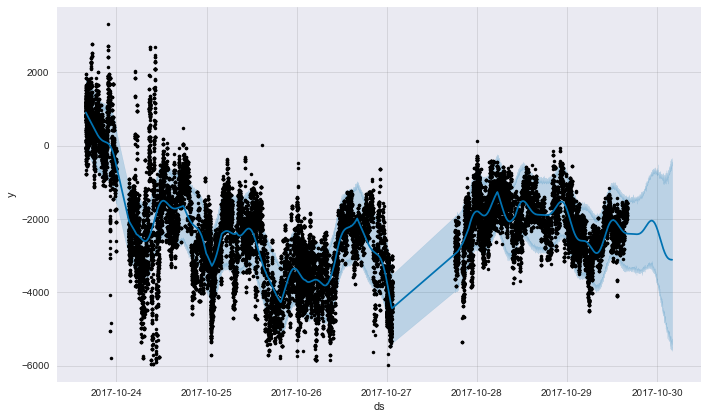

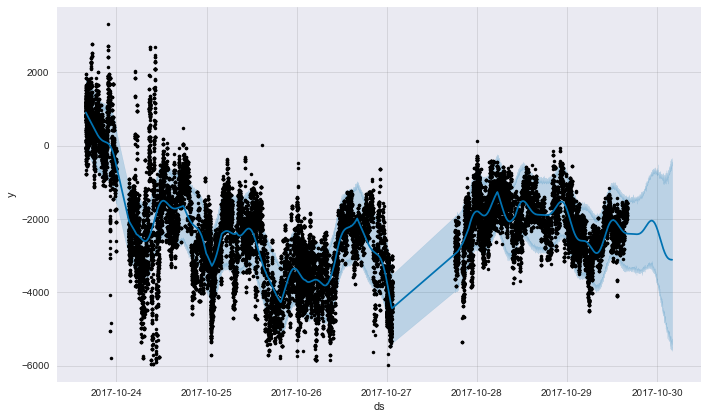

In [8]:
# 今後12時間を予測する
predict_hour = 12
future_ccbid_quask = model_ccbid_quask.make_future_dataframe(periods=predict_hour*60, freq = 'min')
forecast_ccbid_quask = model_ccbid_quask.predict(future_ccbid_quask)
model_ccbid_quask.plot(forecast_ccbid_quask)

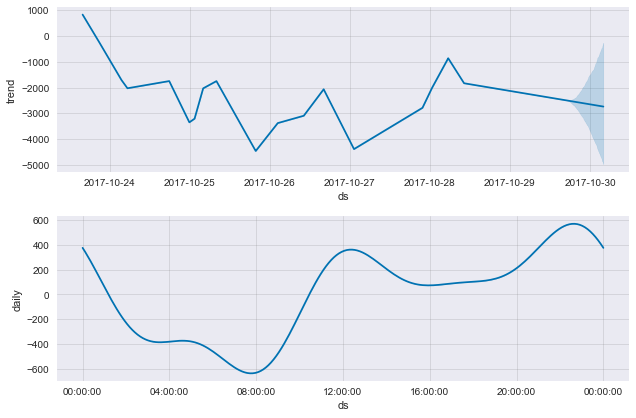

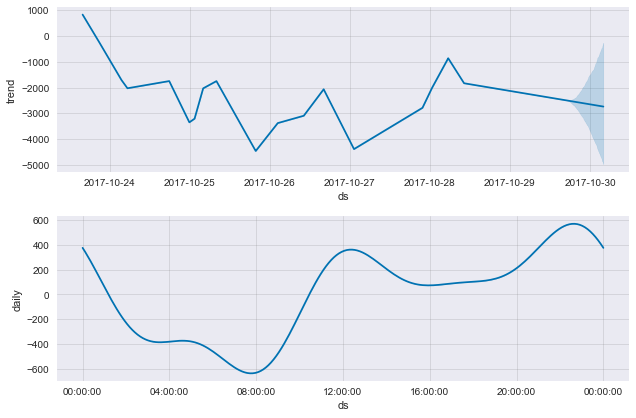

In [11]:
# 要素ごと
model_ccbid_quask.plot_components(forecast_ccbid_quask)

In [15]:
# quoine_bid-quoine_ask
model_qubid_ccask=get_prophetmodel("quoine_bid-coincheck_ask")
# periodは予測期間
future_ccbid_quask = model_qubid_ccask.make_future_dataframe(periods=60*predict_hour, freq = 'min')
forecast_ccbid_quaskt = model_qubid_ccask.predict(future_ccbid_quask)

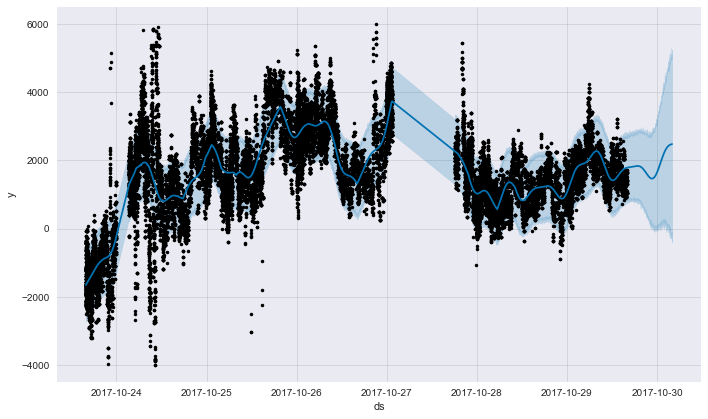

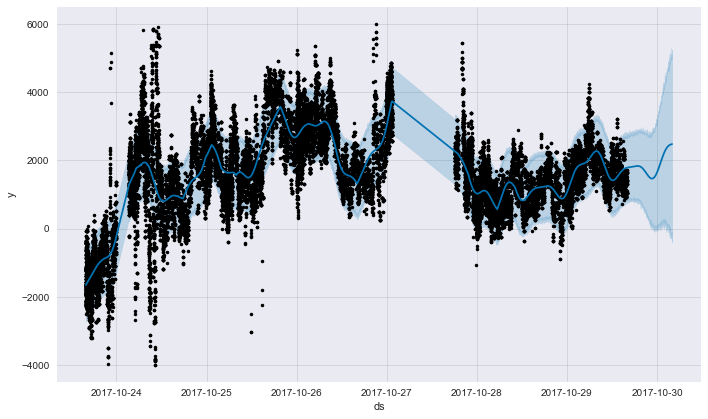

In [16]:
model_qubid_ccask.plot(forecast_ccbid_quaskt)

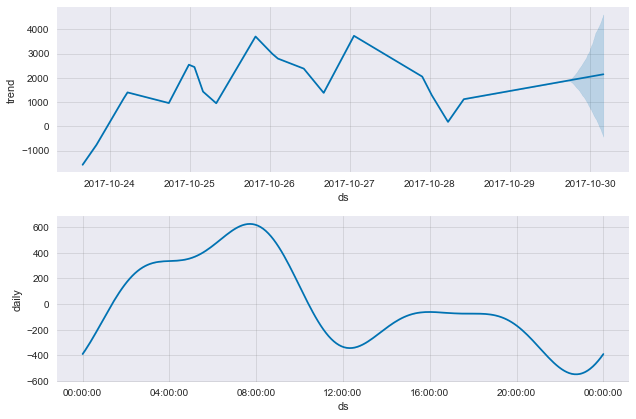

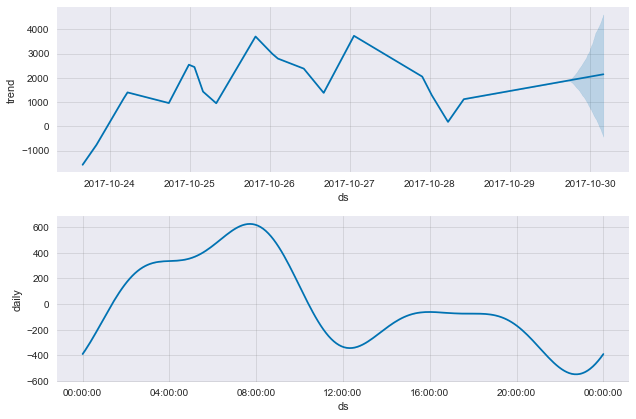

In [17]:
model_qubid_ccask.plot_components(forecast_ccbid_quaskt)

In [19]:
forecast_ccbid_quaskt.columns

Index(['ds', 'trend', 'trend_lower', 'trend_upper', 'yhat_lower', 'yhat_upper',
       'daily', 'daily_lower', 'daily_upper', 'seasonal', 'seasonal_lower',
       'seasonal_upper', 'seasonalities', 'seasonalities_lower',
       'seasonalities_upper', 'yhat'],
      dtype='object')